In [ ]:
Deep Speech 1 by Baidu
Link to Dataset: http://www.openslr.org/resources/12/train-other-500.tar.gz

In [20]:
import os
import sox
import fnmatch
from scipy.io import wavfile
from scipy import signal
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Bidirectional, Dense, Lambda, Dropout, TimeDistributed
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import Nadam
from keras.utils import to_categorical
from keras.callbacks import History
random.seed(10)

In [2]:
source_dir="/home/harsh1405/LibriSpeech/"
target_dir="/home/harsh1405/LibriData/"

In [3]:
#Making a list of iterables for .wav files
z=[]
for file in os.listdir(target_dir):
    if '.wav' in file:
        z.append(file)

In [8]:
#Training Data
audio_frequency=[]
audio=[]
sample_frequency=[]
sample_time=[]
spectrograms=np.ndarray((20000,), dtype='object')
txt=[]
count=0
for file in z[:20000]:
    af, a=wavfile.read(target_dir+file)
    audio_frequency.append(af)
    audio.append(a)
    sf, st, spectro=signal.spectrogram(a, af)
    sample_frequency.append(sf)
    sample_time.append(st)
    spectrograms[count]=spectro
    count+=1
    txt.append(file.split('.')[0])

In [9]:
#Validation Data
audio_frequency_valid=[]
audio_valid=[]
sample_frequency_valid=[]
sample_time_valid=[]
spectrograms_valid=np.ndarray((5000,), dtype='object')
txt_valid=[]
count=0
for file in z[21000:26000]:
    af, a=wavfile.read(target_dir+file)
    audio_frequency_valid.append(af)
    audio_valid.append(a)
    sf, st, spectro=signal.spectrogram(a, af)
    sample_frequency_valid.append(sf)
    sample_time_valid.append(st)
    spectrograms_valid[count]=spectro
    count+=1
    txt_valid.append(file.split('.')[0])

In [10]:
#Adding context frames
for i in range(10000):
    x=np.zeros((7,spectrograms[i].shape[1]))
    spectrograms[i]=np.concatenate((x, spectrograms[i], x))
for i in range(1000):
    x=np.zeros((7,spectrograms_valid[i].shape[1]))
    spectrograms_valid[i]=np.concatenate((x, spectrograms_valid[i], x))

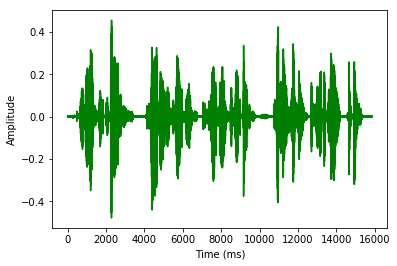

In [11]:
#Graph of one of the samples in audio
audio[0] = audio[0] / (2.**15)
samplePoints = float(audio[0].shape[0])
signalDuration =  audio[0].shape[0] / audio_frequency[0]
timeArray = np.arange(0, samplePoints, 1)
timeArray = timeArray / audio_frequency[0]
timeArray = timeArray * 1000
plt.plot(timeArray, audio[0], color='G')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

In [12]:
def text_to_encoded(text_file):
    text=[]
    for file in text_file:
        file=file+".txt"
        with open(os.path.join(target_dir, file), "r") as fin:
            for line in fin:
                text.append(line)
    
    for i in range(len(text_file)):
        z=text[i]
        z=z.replace(".","")
        z=z.replace(",","")
        z=z.replace(";","")
        z=z.replace(":","")
        z=z.replace("-","")
        z=z.replace("?","")
        z=z.replace("'","")
        z=z.replace('"', '')
        z=z.replace(" ", "  ")
        z=z.split(" ")
        text[i]=z

    space_token="SPACE_TOKEN"
    space_index=0
    alphabets={"a":1, "b":2, "c":3, "d":4, "e":5, "f":6, "g":7, "h":8, "i":9, "j":10, "k":11, "l":12, "m":13, "n":14, \
               "o":15, "p":16, "q":17, "r":18, "s":19, "t":20, "u":21, "v":22, "w":23, "x":24, "y":25, "z":26}
    for i in range(len(text_file)):
        text[i]=np.hstack([space_token if wo=="" else list(wo) for wo in text[i]])
        text[i]=np.asarray([space_index if ch==space_token else alphabets[ch] for ch in text[i]])
    return text

In [30]:
def label_to_text(pred):
    result=[]
    for p in pred:
        if p==0:
            result.append(" ")
        elif p in alphabets.values:
            for alpha, no in alphabets.items():
                if p==no:
                    results.append(alpha)
        else:
            results.append("'") #To show blank generated for ctc label
    "".join(result)
    return result

In [13]:
#Transcriptions encoded into integers
encoded_input_label=text_to_encoded(txt)
encoded_validation_label=text_to_encoded(txt_valid)

In [14]:
class generate_data(object):
    def __init__(self, spectrograms, encoded_input_label, batch_size):
        self.spectro=spectrograms
        self.encod_input_trans=encoded_input_label
        self.batch_size=batch_size
        self.index=0
        self.max_timesteps=max([spect.shape[1] for spect in self.spectro])
        self.max_sequence_trans=max([seq.shape[0] for seq in self.encod_input_trans])
        
    def get_batch(self, ind):
        batch_x=self.spectro[ind*self.batch_size:(ind+1)*self.batch_size]
        batch_y=self.encod_input_trans[ind*self.batch_size:(ind+1)*self.batch_size]
        #Getting input data
        x_val = [spect.shape[1] for spect in batch_x] #For max. length of timeseries
        max_x_val=max(x_val)
        X_data=np.array([self.make_specto_for_input(spect, max_x_val) for spect in batch_x])
        #Getting output data
        y_val=[seq.shape[0] for seq in batch_y] #For max length of a sequence
        max_y_val=max(y_val) 
        Y_data=np.array([self.make_seq_for_input(seq, max_y_val) for seq in batch_y])
        #For CTC
        input_length=np.array(x_val)
        label_length=np.array(y_val)
            
        inps = {'inp_data':X_data, 'out_labels':Y_data, 'inp_len':input_length, 'out_len':label_length}
        outps= {'ctc':np.zeros([self.batch_size])}
        return (inps, outps)
        
    def next_batch(self):
        while True: #For no StopIteration
            if (self.index+1)*self.batch_size >= self.spectro.size:
                self.index=0
            ret=self.get_batch(self.curr_index)
            self.index+=1
            yield ret
            
    def make_specto_for_input(self, specto, padlength=None):
        if padlength is None:
            padlength=self.max_timesteps
        specto=pad_sequences(specto, maxlen=padlength, dtype='float', padding='post', truncating='post')
        specto=specto.T
        return specto
        
    def make_seq_for_input(self, seq, padlength=None):
        if padlength is None:
            padlength=self.max_sequence_trans
        while(len(seq)<padlength):
            seq=np.append(seq, 0)
        return seq

In [23]:
def ctc_lambda(args):    
    predictions, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, predictions, input_length, label_length)
def ctc(labels, predictions):
    return predictions
#Model
inp_s=Input(shape=(None, 143), name='inp_data')
model=TimeDistributed(Dense(512, activation='relu'))(inp_s)
model=Dropout(0.05)(model)
model=TimeDistributed(Dense(512, activation='relu'))(model)
model=Dropout(0.05)(model)
model=TimeDistributed(Dense(512, activation='relu'))(model)
model=Dropout(0.05)(model)
model=Bidirectional(SimpleRNN(512, return_sequences=True), merge_mode='sum')(model)
model=TimeDistributed(Dense(512, activation='relu'))(model)
model=Dropout(0.05)(model)
predictions=TimeDistributed(Dense(28, activation='softmax'))(model)

#CTC Layers in model
labels=Input(shape=[None,], dtype='int32', name='out_labels')
input_length=Input(shape=[1], dtype='int32', name='inp_len')
output_length=Input(shape=[1], dtype='int32', name='out_len')
output_loss=Lambda(ctc_lambda, output_shape=(1,), name='ctc')([predictions, labels, input_length, output_length])

model=Model(inputs=[inp_s, labels, input_length, output_length], outputs=output_loss)

In [24]:
optimize=Nadam() #For Nesterov's gradient on Adam optimizer
model.compile(loss=ctc, optimizer=optimize)
train_data=generate_data(spectrograms, encoded_input_label, batch_size=100)
valid_data=generate_data(spectrograms_valid, encoded_validation_label, batch_size=100)
#predict_function = K.function([model.get_layer('inp_data').input, K.learning_phase()], [model.get_layer('ctc').input[0]])

In [25]:
#model=load_weights('/home/harsh1405/DSBaidu_model.h5')
model.fit_generator(generator=train_data.next_batch(), steps_per_epoch=200, epochs=3, validation_data=\
                    valid_data.next_batch(), validation_steps=50,verbose=1)

Epoch 1/3
100/100 [==============================] - 397s 4s/step - loss: 654.6076 - val_loss: 538.0319
Epoch 2/3
100/100 [==============================] - 396s 4s/step - loss: 536.5839 - val_loss: 510.1798
Epoch 3/3
100/100 [==============================] - 395s 4s/step - loss: 515.9286 - val_loss: 501.4065


In [26]:
model.save_weights('/home/harsh1405/DSBaidu_model_weights.h5')